#### Import Libraries

In [1]:
# data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# progress bar
from tqdm.notebook import tqdm

# dimensionality reduction (for visualization)
#from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Data Preparation

In [2]:
articles = pd.read_csv('input/h-and-m-personalized-fashion-recommendations/articles.csv')
customers = pd.read_csv('input/h-and-m-personalized-fashion-recommendations/customers.csv')
transactions = pd.read_csv('input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
print(articles.shape, customers.shape, transactions.shape)

(105542, 25) (1371980, 7) (31788324, 5)


We will use only a small portion of the data for the purposes of our analysis. For actual analysis, it is better to use a lot of resources and perform it with the entire data.

In [3]:
# choose portion
transactions = transactions[:100000]

To define customer representation, it is necessary to bring related data into one table. Based on some selected transactions, the data is combined into one table.

In [4]:
# we just need "customer_id", "article_id", "price" columns.
transactions = transactions[["customer_id", "article_id", "price"]]
transactions

,customer_id,article_id,price
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932
...,...,...,...
99995,398767f185a935edc17cc5db5a346ead3649b08be7b310...,516859002,0.013542
99996,398767f185a935edc17cc5db5a346ead3649b08be7b310...,534357008,0.067780
99997,398767f185a935edc17cc5db5a346ead3649b08be7b310...,487722001,0.042356
99998,398767f185a935edc17cc5db5a346ead3649b08be7b310...,684686001,0.050831


In [5]:
# we only need "customer_id", "age"
customers = customers[["customer_id", "age"]]
customers

,customer_id,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,24.0
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,21.0
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,21.0
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,18.0


In [6]:
# We will use category information from articles, other columns don't need.
articles = articles[["article_id", "prod_name", "product_type_name", "product_group_name",
                     "department_name", "index_name", "index_group_name",
                     "section_name", "garment_group_name"]]
articles

,article_id,prod_name,product_type_name,product_group_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,108775044,Strap top,Vest top,Garment Upper body,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,108775051,Strap top (1),Vest top,Garment Upper body,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,110065001,OP T-shirt (Idro),Bra,Underwear,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,110065002,OP T-shirt (Idro),Bra,Underwear,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
...,...,...,...,...,...,...,...,...,...
105537,953450001,5pk regular Placement1,Socks,Socks & Tights,Socks Bin,Menswear,Menswear,Men Underwear,Socks and Tights
105538,953763001,SPORT Malaga tank,Vest top,Garment Upper body,Jersey,Ladieswear,Ladieswear,H&M+,Jersey Fancy
105539,956217002,Cartwheel dress,Dress,Garment Full body,Jersey,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy
105540,957375001,CLAIRE HAIR CLAW,Hair clip,Accessories,Small Accessories,Divided,Divided,Divided Accessories,Accessories


In [7]:
# merge into just one table!
temp = pd.merge(transactions, articles, on="article_id", how='inner')
temp = pd.merge(temp, customers, on="customer_id", how='inner')
temp

,customer_id,article_id,price,prod_name,product_type_name,product_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,age
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,Atlanta Push Body Harlow,Underwear body,Underwear,Expressive Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",24.0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,Rae Push (Melbourne) 2p,Bra,Underwear,Casual Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",24.0
2,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,Atlanta Push Body Harlow,Underwear body,Underwear,Expressive Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",30.0
3,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,537346026,0.041237,Ridge,Sweater,Garment Upper body,Knitwear,Ladieswear,Ladieswear,Womens Everyday Collection,Knitwear,30.0
4,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,682965001,0.024729,Clemenza Push Balboa (1),Bra,Underwear,Expressive Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",30.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3031f6eee1fde42eba7e465aedb4c4fc7e460ec068d4de...,553092016,0.101678,Hunter Super Skinny,Blazer,Garment Upper body,Blazer S&T,Menswear,Menswear,Men Suits & Tailoring,Dressed,54.0
99996,31f3cf34623bf733f7b7db222ef889733b7000fce49fe5...,605970005,0.033881,Linnea PJ (K),Pyjama set,Nightwear,Nightwear,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh","Under-, Nightwear",34.0
99997,32e4f40326b0da0562ae2a70bb98cc3da9dfd57c07451d...,656121004,0.067780,Akoni Shoe,Other shoe,Shoes,Shoes / Boots inactive from s5,Menswear,Menswear,Men Shoes,Shoes,39.0
99998,35db9f48899a704929534735148b9ce5d6610246b66ab2...,365102037,0.005068,Urban USB cable,Other accessories,Accessories,Other Accessories,Divided,Divided,Divided Accessories,Accessories,23.0


In [8]:
# check null values and drop it.
display(temp[temp.isnull().any(axis=1)])
temp = temp.dropna()

,customer_id,article_id,price,prod_name,product_type_name,product_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,age
709,577bc5bfb2a8d280292182def807f6359a477a20c434bf...,685687003,0.016932,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Campaigns,Ladieswear,Ladieswear,Womens Everyday Collection,Special Offers,NaN
710,577bc5bfb2a8d280292182def807f6359a477a20c434bf...,685687004,0.016932,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Campaigns,Ladieswear,Ladieswear,Womens Everyday Collection,Special Offers,NaN
711,577bc5bfb2a8d280292182def807f6359a477a20c434bf...,680374003,0.032186,Liddy,Blouse,Garment Upper body,Blouse,Ladieswear,Ladieswear,Womens Everyday Collection,Blouses,NaN
712,577bc5bfb2a8d280292182def807f6359a477a20c434bf...,617534007,0.011847,Lova Linen v neck,T-shirt,Garment Upper body,Jersey,Ladieswear,Ladieswear,Womens Casual,Jersey Fancy,NaN
713,577bc5bfb2a8d280292182def807f6359a477a20c434bf...,684588006,0.025407,Yen.,Blouse,Garment Upper body,Blouse,Ladieswear,Ladieswear,Womens Everyday Collection,Blouses,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
99636,63f705bcaf510c79143cec4bdd09023686bf15e88aae4d...,525111001,0.003373,Classic Clubba glasses,Other accessories,Accessories,Sunglasses,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,NaN
99709,79ac70230bc27fc3737976236bde7fb384b2b2bdb05f69...,682623002,0.016932,Bibi 4-p kneehigh,Socks,Socks & Tights,Kids Girl S&T,Children Sizes 92-140,Baby/Children,Girls Underwear & Basics,Socks and Tights,NaN
99710,79ac70230bc27fc3737976236bde7fb384b2b2bdb05f69...,682623002,0.016932,Bibi 4-p kneehigh,Socks,Socks & Tights,Kids Girl S&T,Children Sizes 92-140,Baby/Children,Girls Underwear & Basics,Socks and Tights,NaN
99832,a567cceed7bd61f7ed881820fd6ccf13b1ec9dc5ddc983...,667928001,0.042356,LOGG Vimmerby,Top,Garment Upper body,Woven top,Ladieswear,Ladieswear,H&M+,Blouses,NaN


In [9]:
# grab some garbage
import gc
gc.collect()

40

### 2. How to represent customers?

There are many different ways to define the characteristics of a customer.
We will use the customer age and the article category info the customer has purchased.
Each customer will be presented with a numerical value based on which item they purchased.
The data represented is defined as a feature vector, after that clustering is performed.


There are many categories we can choose from articles table, we'll start with the highest level first.

In [10]:
# find highest level of groups
for col in ["prod_name", "product_type_name", "product_group_name",
            "department_name", "index_name", "index_group_name",
            "section_name", "garment_group_name"]:
    print(f"{col}\t>> {temp[col].nunique()} number of unique categories.")

prod_name	>> 8915 number of unique categories.
product_type_name	>> 95 number of unique categories.
product_group_name	>> 14 number of unique categories.
department_name	>> 225 number of unique categories.
index_name	>> 10 number of unique categories.
index_group_name	>> 5 number of unique categories.
section_name	>> 55 number of unique categories.
garment_group_name	>> 21 number of unique categories.


In [11]:
# define customer-article matrix
ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_name)
ca_matrix

index_group_name,Baby/Children,Divided,Ladieswear,Menswear,Sport
customer_id,,,,,
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0,2,1,0,0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0,0,2,0,0
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0,2,3,0,0
0003abe64294e66a6310c3436fa9e5b754cc5603deef4f26fc8ab8d043af9358,0,3,1,0,0
0004068f54dbe1c7054b23c615edc5f733a508ecc54930bf323209f20410898c,0,0,1,0,1
...,...,...,...,...,...
fff3e75605ec575be9b95eda1e6557299e81bba12668d750c0e973528e48b7ee,0,0,5,0,0
fff4b145d7469e023b147b0f8375c565b1be43944987792153ccc0af41466cf3,0,1,2,0,0
fff627c97a69e53afb4a2b49a3ebf7fa06660afaac959b46e8080849008fe17c,0,0,2,0,4


In [12]:
# Get average prices they've been bought.
prices = temp.groupby(["customer_id"])["price"].mean()
prices

customer_id
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa    0.042356
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318    0.040661
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2    0.017271
0003abe64294e66a6310c3436fa9e5b754cc5603deef4f26fc8ab8d043af9358    0.029644
0004068f54dbe1c7054b23c615edc5f733a508ecc54930bf323209f20410898c    0.016085
                                                                      ...   
fff3e75605ec575be9b95eda1e6557299e81bba12668d750c0e973528e48b7ee    0.021678
fff4b145d7469e023b147b0f8375c565b1be43944987792153ccc0af41466cf3    0.015802
fff627c97a69e53afb4a2b49a3ebf7fa06660afaac959b46e8080849008fe17c    0.037554
fff969b13a1c848d53ae3f08f111bfebcdcf6cd27e3815235db95f1e99524c79    0.020322
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264    0.042356
Name: price, Length: 28138, dtype: float64

In [13]:
# get customer ages
ages = temp.groupby(["customer_id"])["age"].mean()
ages

customer_id
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa    25.0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318    24.0
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2    32.0
0003abe64294e66a6310c3436fa9e5b754cc5603deef4f26fc8ab8d043af9358    51.0
0004068f54dbe1c7054b23c615edc5f733a508ecc54930bf323209f20410898c    51.0
                                                                    ... 
fff3e75605ec575be9b95eda1e6557299e81bba12668d750c0e973528e48b7ee    33.0
fff4b145d7469e023b147b0f8375c565b1be43944987792153ccc0af41466cf3    56.0
fff627c97a69e53afb4a2b49a3ebf7fa06660afaac959b46e8080849008fe17c    47.0
fff969b13a1c848d53ae3f08f111bfebcdcf6cd27e3815235db95f1e99524c79    52.0
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264    21.0
Name: age, Length: 28138, dtype: float64

In [14]:
# merge them into one table
train = pd.merge(ca_matrix, prices, on="customer_id", how="left")
train = pd.merge(train, ages, on="customer_id", how="left")
train

,Baby/Children,Divided,Ladieswear,Menswear,Sport,price,age
customer_id,,,,,,,
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0,2,1,0,0,0.042356,25.0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0,0,2,0,0,0.040661,24.0
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0,2,3,0,0,0.017271,32.0
0003abe64294e66a6310c3436fa9e5b754cc5603deef4f26fc8ab8d043af9358,0,3,1,0,0,0.029644,51.0
0004068f54dbe1c7054b23c615edc5f733a508ecc54930bf323209f20410898c,0,0,1,0,1,0.016085,51.0
...,...,...,...,...,...,...,...
fff3e75605ec575be9b95eda1e6557299e81bba12668d750c0e973528e48b7ee,0,0,5,0,0,0.021678,33.0
fff4b145d7469e023b147b0f8375c565b1be43944987792153ccc0af41466cf3,0,1,2,0,0,0.015802,56.0
fff627c97a69e53afb4a2b49a3ebf7fa06660afaac959b46e8080849008fe17c,0,0,2,0,4,0.037554,47.0


When using distance-based machine learning models, feature scaling must be performed.

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler().fit_transform(train)
X = pd.DataFrame(data=scaled, columns=train.columns, index=train.index)
X

,Baby/Children,Divided,Ladieswear,Menswear,Sport,price,age
customer_id,,,,,,,
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0.0,0.033333,0.019231,0.0,0.000000,0.070273,0.098765
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.0,0.000000,0.038462,0.0,0.000000,0.067403,0.086420
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0.0,0.033333,0.057692,0.0,0.000000,0.027805,0.185185
0003abe64294e66a6310c3436fa9e5b754cc5603deef4f26fc8ab8d043af9358,0.0,0.050000,0.019231,0.0,0.000000,0.048752,0.419753
0004068f54dbe1c7054b23c615edc5f733a508ecc54930bf323209f20410898c,0.0,0.000000,0.019231,0.0,0.038462,0.025796,0.419753
...,...,...,...,...,...,...,...
fff3e75605ec575be9b95eda1e6557299e81bba12668d750c0e973528e48b7ee,0.0,0.000000,0.096154,0.0,0.000000,0.035265,0.197531
fff4b145d7469e023b147b0f8375c565b1be43944987792153ccc0af41466cf3,0.0,0.016667,0.038462,0.0,0.000000,0.025318,0.481481
fff627c97a69e53afb4a2b49a3ebf7fa06660afaac959b46e8080849008fe17c,0.0,0.000000,0.038462,0.0,0.153846,0.062143,0.370370


### 3. How to make a group with similar customers?

Usually, we use insights or statistics from existing research to segment customers.
We use machine learning methods to practice how to construct a customer segment.


We use "clustering", an unsupervised settings, because we don't know which customer belongs to which customer group.

In [16]:
# we segment 28,317 users into 8 groups by using K-means clustering.

model = KMeans()
preds = model.fit_predict(X)  # no needed 'y'
print("SSE : ", model.inertia_)
print("Silhouette Score : %.4f" % silhouette_score(X, preds))

SSE :  172.94738391095774
Silhouette Score : 0.2566


To find optimal number of clusters, we can use elbow methods.

OR

we can use silhouette scores as metric.

In [17]:
sses = []
scores = []
N = list(range(2, 11))  # check between K=2 to K=10

for n_clusters in tqdm(N):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    preds = model.fit_predict(X)
    sse = model.inertia_
    score = silhouette_score(X, preds)
    sses.append(sse)
    scores.append(score)

#### Plot the result

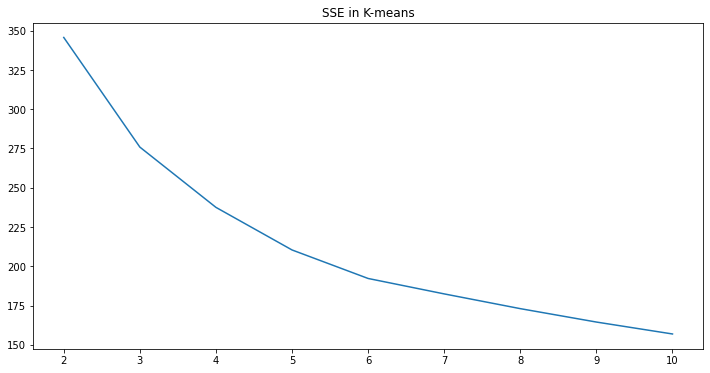

In [18]:
# SSE
plt.figure(figsize=(12, 6))
plt.title("SSE in K-means")
sns.lineplot(x=N, y=sses)
plt.show()

By looking above graph, we derive best **K=4** with elbow methods.

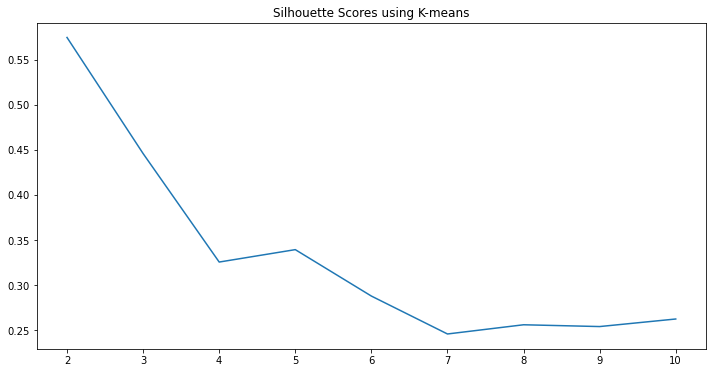

In [19]:
# Silhouette
plt.figure(figsize=(12, 6))
plt.title("Silhouette Scores using K-means")
sns.lineplot(x=N, y=scores)
plt.show()

By looking above graph, we derive best **K=2** using silhouette scores.

#### Select best K=4, see the final result!

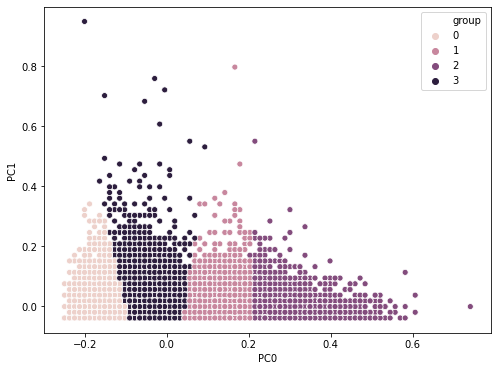

In [20]:
# visualize the result
# if you want to use PCA, then uncomment PCA related codes.
# if you want to use full data, try MiniBatchSparsePCA.
from sklearn.decomposition import MiniBatchSparsePCA

#pca = PCA(n_components=2)
#tsne = TSNE(n_components=2, perplexity=50, random_state=42)
#svd = TruncatedSVD(n_components=2, )
pca = MiniBatchSparsePCA(n_components=2, batch_size=100000, random_state=42)

X_reduced = pca.fit_transform(X)
#X_reduced = tsne.fit_transform(X)
pca_df = pd.DataFrame(data=X_reduced,
                     columns=[f"PC{i}" for i in range(X_reduced.shape[1])])

# tsne_df = pd.DataFrame(data=X_reduced,
#                        columns=[f"dim{i}" for i in range(1, X_reduced.shape[1]+1)])


# finalize cluster model
# with sse
result_sse = KMeans(n_clusters=4).fit_predict(X)

# with silhouette
#result_silhouette = KMeans(n_clusters=2).fit_transform(X)

pca_df['group'] = result_sse
#tsne_df['group'] = result_sse

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC0", y="PC1", hue="group")
#sns.scatterplot(data=tsne_df, x="dim1", y="dim2", hue="group")
plt.show()